In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch import Tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from google.colab import files
uploaded = files.upload()
uploaded = files.upload()

Saving train_dataset_v1.csv to train_dataset_v1.csv


Saving test_dataset_v1.csv to test_dataset_v1.csv


In [2]:
test_vals = pd.read_csv('test_dataset_v1.csv')
train_vals = pd.read_csv('train_dataset_v1.csv')

In [3]:
len(test_vals)

40

In [4]:
test_vals = pd.read_csv('test_dataset_v1.csv')
train_vals = pd.read_csv('train_dataset_v1.csv')
test_vals['Datetime'] = (
    test_vals['Datetime']
    .str.split('+').str[0]          # Remove timezone info
    .str.replace('-', '', regex=False)  # Remove dashes
    .str.split(':').str[0]          # Keep only hour part
)

test_vals[['Date', 'Time']] = test_vals['Datetime'].str.split(' ', expand=True)
test_vals.drop(columns=['Unit','Datetime'], inplace=True)

train_vals['Datetime'] = (
    train_vals['Datetime']
    .str.split('+').str[0]          # Remove timezone info
    .str.replace('-', '', regex=False)  # Remove dashes
    .str.split(':').str[0]          # Keep only hour part
)

train_vals[['Date', 'Time']] = train_vals['Datetime'].str.split(' ', expand=True)
train_vals.drop(columns=['Unit','Datetime'], inplace=True)
test_vals['Date'] = pd.to_numeric(test_vals['Date'], errors='coerce')
test_vals['Time'] = pd.to_numeric(test_vals['Time'], errors='coerce')
train_vals['Date'] = pd.to_numeric(train_vals['Date'], errors='coerce')
train_vals['Time'] = pd.to_numeric(train_vals['Time'], errors='coerce')



In [5]:
train_vals.head()

,Open,High,Low,Close,Volume,Date,Time
0,117625.382812,117768.789062,117201.156250,117498.921875,7876534272,20250726,0
1,117495.921875,118219.609375,117357.320312,117827.984375,8697057280,20250726,6
2,117817.687500,118274.765625,117805.625000,118068.562500,8017883136,20250726,12
3,118072.210938,118324.984375,117929.156250,117946.296875,8409116672,20250726,18
4,117991.445312,118384.382812,117872.500000,118334.046875,9951830016,20250727,0


In [6]:
for cols in train_vals.columns:
  print(train_vals[cols].dtype)

float64
float64
float64
float64
int64
int64
int64


In [7]:
train_array = train_vals.to_numpy()
train_tensor = torch.from_numpy(train_array).squeeze()
test_array = test_vals.to_numpy()
test_tensor = torch.from_numpy(test_array).squeeze()

In [8]:
train_tensor

tensor([[1.1763e+05, 1.1777e+05, 1.1720e+05, 1.1750e+05, 7.8765e+09, 2.0251e+07,
         0.0000e+00],
        [1.1750e+05, 1.1822e+05, 1.1736e+05, 1.1783e+05, 8.6971e+09, 2.0251e+07,
         6.0000e+00],
        [1.1782e+05, 1.1827e+05, 1.1781e+05, 1.1807e+05, 8.0179e+09, 2.0251e+07,
         1.2000e+01],
        [1.1807e+05, 1.1832e+05, 1.1793e+05, 1.1795e+05, 8.4091e+09, 2.0251e+07,
         1.8000e+01],
        [1.1799e+05, 1.1838e+05, 1.1787e+05, 1.1833e+05, 9.9518e+09, 2.0251e+07,
         0.0000e+00],
        [1.1833e+05, 1.1844e+05, 1.1791e+05, 1.1809e+05, 1.0806e+10, 2.0251e+07,
         6.0000e+00],
        [1.1812e+05, 1.1954e+05, 1.1793e+05, 1.1922e+05, 1.7502e+10, 2.0251e+07,
         1.2000e+01],
        [1.1927e+05, 1.1979e+05, 1.1877e+05, 1.1946e+05, 1.8477e+10, 2.0251e+07,
         1.8000e+01],
        [1.1944e+05, 1.1979e+05, 1.1902e+05, 1.1961e+05, 2.1284e+10, 2.0251e+07,
         0.0000e+00],
        [1.1955e+05, 1.1961e+05, 1.1853e+05, 1.1881e+05, 2.2408e+10, 2.02

In [16]:
# ====== Dataset ======
class StockDataset(Dataset):
    def __init__(self, data_input, lookback=5, scaler=None):
        self.lookback = lookback

        # Handle DataFrame with 7 cols (drop Date, Time)
        if isinstance(data_input, pd.DataFrame):
            data = data_input[['Open', 'High', 'Low', 'Close', 'Volume']].values
        else:  # Tensor or numpy
            data = data_input if isinstance(data_input, np.ndarray) else data_input.numpy()
            # If numpy/tensor has 7 cols, take only first 5
            if data.shape[1] >= 7:
                data = data[:, :5]

        # Scale
        if scaler is None:
            self.scaler = MinMaxScaler()
            data = self.scaler.fit_transform(data)
        else:
            self.scaler = scaler
            data = self.scaler.transform(data)

        data = torch.tensor(data, dtype=torch.float32)

        self.X, self.y = [], []
        for i in range(len(data) - lookback):
            self.X.append(data[i:i+lookback])
            self.y.append(data[i+lookback][[0, 1, 3]])  # Open, High, Close

        self.X = torch.stack(self.X)
        self.y = torch.stack(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]



# ====== Model ======
class StockPredictor(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, output_size=3, num_layers=2):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out



# ====== Training Function ======
def train_model(train_data, lookback=5, epochs=50, batch_size=32, lr=0.001):
    dataset = StockDataset(train_data, lookback=lookback)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)  # keep sequential order

    model = StockPredictor()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if epoch % 5 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {total_loss/len(dataloader):.6f}")

    return model, dataset.scaler


# ====== Prediction Function ======
def predict_next_day(model, scaler, recent_data, lookback=5):
    model.eval()
    with torch.inference_mode():
        if isinstance(recent_data, pd.DataFrame):
            # Drop Date/Time if they exist
            recent_values = recent_data[['Open', 'High', 'Low', 'Close', 'Volume']].values
        else:
            recent_values = recent_data if isinstance(recent_data, np.ndarray) else recent_data.numpy()
            # If 7 cols, take only first 5
            if recent_values.shape[1] >= 7:
                recent_values = recent_values[:, :5]

        recent_scaled = scaler.transform(recent_values[-lookback:])
        recent_scaled = torch.tensor(recent_scaled, dtype=torch.float32).unsqueeze(0)

        pred_scaled = model(recent_scaled).numpy()

        # Inverse scaling (Open, High, Close only)
        dummy = np.zeros((1, 5))
        dummy[0, [0, 1, 3]] = pred_scaled[0]
        pred_original = scaler.inverse_transform(dummy)[0, [0, 1, 3]]

        return pred_original



if __name__ == "__main__":

    model, scaler = train_model(train_tensor, lookback=5, epochs=50)

    # Save model + scaler
    # # torch.save({
    # #     "model_state": model.state_dict(),
    # #     "scaler": scaler
    # # }, "stock_predictor.pth")

    # print("Model saved as stock_predictor.pth")

    prediction = predict_next_day(model, scaler, test_tensor, lookback=5)
    print("Predicted Next Day [Open, High, Close]:", prediction)


Epoch 5/50, Loss: 0.158830
Epoch 10/50, Loss: 0.050345
Epoch 15/50, Loss: 0.036384
Epoch 20/50, Loss: 0.029776
Epoch 25/50, Loss: 0.018767
Epoch 30/50, Loss: 0.013477
Epoch 35/50, Loss: 0.011994
Epoch 40/50, Loss: 0.010582
Epoch 45/50, Loss: 0.009560
Epoch 50/50, Loss: 0.008659
Predicted Next Day [Open, High, Close]: [120523.5243282  120997.6863707  120203.49868003]


In [18]:
# ====== Model Definition (must match training) ======
class StockPredictor(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, output_size=3, num_layers=2):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


# ====== Load Model + Scaler ======
def load_model(path="stock_predictor.pth"):
    checkpoint = torch.load(path, map_location=torch.device("cpu"))
    model = StockPredictor()
    model.load_state_dict(checkpoint["model_state"])
    model.eval()
    scaler = checkpoint["scaler"]
    return model, scaler


# ====== Multi-step Forecast ======
def forecast_next_days(model, scaler, data, lookback=5, steps=40):
    """
    Forecasts 'steps' future points in 6h intervals.
    """
    values = data[['Open', 'High', 'Low', 'Close', 'Volume']].values
    scaled = scaler.transform(values)

    seq = torch.tensor(scaled[-lookback:], dtype=torch.float32).unsqueeze(0)

    preds = []
    for _ in range(steps):
        with torch.no_grad():
            pred_scaled = model(seq).numpy()

        # Inverse scaling
        dummy = np.zeros((1, 5))
        dummy[0, [0, 1, 3]] = pred_scaled[0]
        pred_original = scaler.inverse_transform(dummy)[0, [0, 1, 3]]
        preds.append(pred_original)

        # Append new prediction into sequence (keeping Low=Close, Volume=same last val as placeholder)
        new_row = np.zeros((1, 5))
        new_row[0, [0, 1, 3]] = pred_scaled[0]
        new_row[0, 2] = seq[0, -1, 2].item()      # reuse last Low
        new_row[0, 4] = seq[0, -1, 4].item()      # reuse last Volume

        new_row = torch.tensor(new_row, dtype=torch.float32)
        seq = torch.cat([seq[:, 1:, :], new_row.unsqueeze(0)], dim=1)

    return np.array(preds)


# ====== Main ======
if __name__ == "__main__":
    # Load model
    # model, scaler = load_model("stock_predictor.pth")
    model = model
    # Load test dataset
    test_df = pd.read_csv("test_dataset_v1.csv")

    # Forecast 40 steps (10 days, 6h intervals)
    preds = forecast_next_days(model, scaler, test_df, lookback=5, steps=40)

    # Build output dataframe with Date + Time
    last_datetime = pd.to_datetime(test_df['Datetime'].iloc[-1])
    future_datetimes = [last_datetime + pd.Timedelta(hours=6*(i+1)) for i in range(40)]

    out_df = pd.DataFrame({
        "Date": [dt.strftime("%Y%m%d") for dt in future_datetimes],
        "Time": [dt.strftime("%H") for dt in future_datetimes],
        "Pred_Open": preds[:, 0],
        "Pred_High": preds[:, 1],
        "Pred_Close": preds[:, 2],
    })

    out_df.to_csv("10day_predictions.csv", index=False)
    print("Saved 10-day forecast to 10day_predictions.csv")


Saved 10-day forecast to 10day_predictions.csv


In [20]:
# ====== Model Definition ======
class StockPredictor(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, output_size=3, num_layers=2):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


# ====== Load Model + Scaler ======
def load_model(path="stock_predictor.pth"):
    checkpoint = torch.load(path, map_location=torch.device("cpu"))
    model = StockPredictor()
    model.load_state_dict(checkpoint["model_state"])
    model.eval()
    scaler = checkpoint["scaler"]
    return model, scaler


# ====== Multi-step Forecast ======
def forecast_fixed_range(model, scaler, data, start_date, end_date, lookback=5):
    """
    Forecasts between given start and end dates (6h intervals).
    """
    values = data[['Open', 'High', 'Low', 'Close', 'Volume']].values
    scaled = scaler.transform(values)

    seq = torch.tensor(scaled[-lookback:], dtype=torch.float32).unsqueeze(0)
    future_datetimes = pd.date_range(start=start_date, end=end_date, freq="6H")

    preds = []
    for _ in range(len(future_datetimes)):
        with torch.no_grad():
            pred_scaled = model(seq).numpy()

        dummy = np.zeros((1, 5))
        dummy[0, [0, 1, 3]] = pred_scaled[0]
        pred_original = scaler.inverse_transform(dummy)[0, [0, 1, 3]]
        preds.append(pred_original)

        new_row = np.zeros((1, 5))
        new_row[0, [0, 1, 3]] = pred_scaled[0]
        new_row[0, 2] = seq[0, -1, 2].item()
        new_row[0, 4] = seq[0, -1, 4].item()

        new_row = torch.tensor(new_row, dtype=torch.float32)
        seq = torch.cat([seq[:, 1:, :], new_row.unsqueeze(0)], dim=1)

    return np.array(preds), future_datetimes


# ====== Main ======
if __name__ == "__main__":
    # Load model
    model, scaler = load_model("stock_predictor.pth")
    test_df = pd.read_csv("test_dataset.csv")

    # Forecast between fixed range
    preds, future_datetimes = forecast_fixed_range(
        model, scaler,
        test_df,
        start_date="2025-08-05 00:00:00",
        end_date="2025-08-14 23:59:59",
        lookback=5
    )

    # Build output dataframe
    out_df = pd.DataFrame({
        "Date": [dt.strftime("%Y%m%d") for dt in future_datetimes],
        "Time": [dt.strftime("%H") for dt in future_datetimes],
        "Pred_Open": preds[:, 0],
        "Pred_High": preds[:, 1],
        "Pred_Close": preds[:, 2],
    })

    out_df.to_csv("predictions_5to14Aug.csv", index=False)
    print("Saved forecast to predictions_5to14Aug.csv")


Saved forecast to predictions_5to14Aug.csv


/tmp/ipython-input-3199225688.py:41: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_datetimes = pd.date_range(start=start_date, end=end_date, freq="6H")


In [23]:
pred_data = pd.read_csv('/content/predictions_5to14Aug.csv')

In [24]:
pred_data.head()

,Date,Time,Pred_Open,Pred_High,Pred_Close
0,20250805,0,120523.524328,120997.686371,120203.498680
1,20250805,6,119662.327042,120115.522105,119374.611894
2,20250805,12,118723.231990,119168.085551,118470.630193
3,20250805,18,118282.481339,118728.746227,118054.878013
4,20250806,0,118431.317610,118882.609606,118208.266910


In [26]:
wanted = pred_data['Pred_Open']
reqd = test_vals['Open']

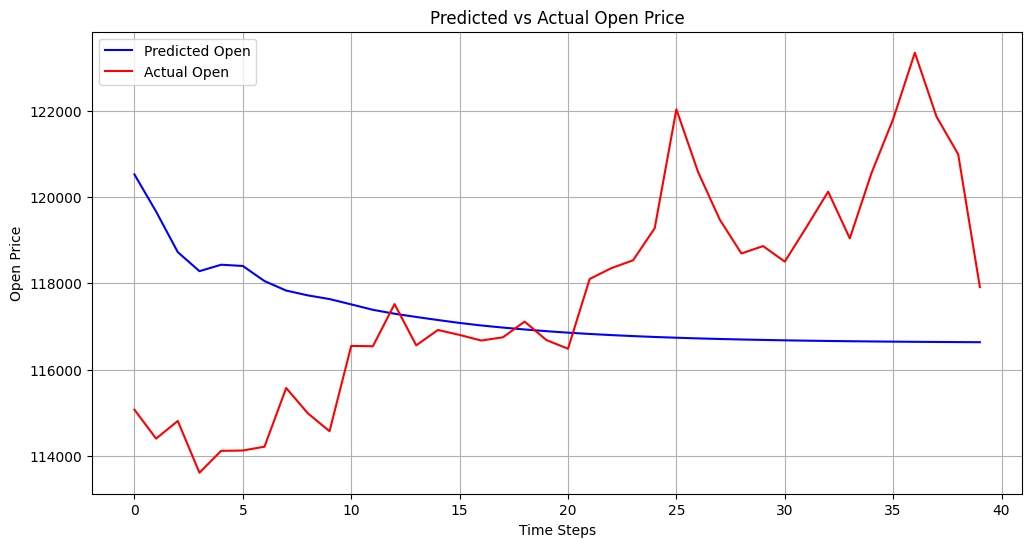

In [27]:
# Assuming you already have:
# wanted = pred_data['Pred_Open']
# reqd   = test_vals['Open']

plt.figure(figsize=(12, 6))

plt.plot(wanted, label="Predicted Open", color="blue")
plt.plot(reqd, label="Actual Open", color="red")

plt.xlabel("Time Steps")
plt.ylabel("Open Price")
plt.title("Predicted vs Actual Open Price")
plt.legend()
plt.grid(True)
plt.show()


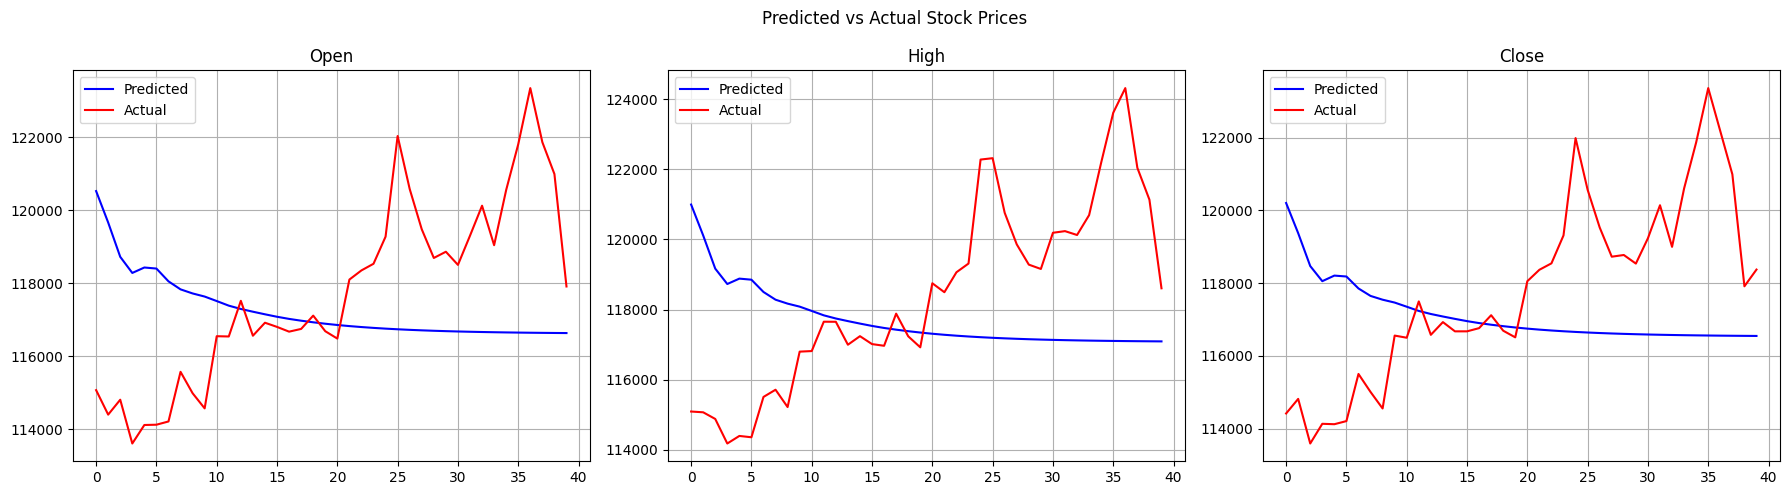

In [28]:
# Example: predicted vs actual (replace with your DataFrame column names)
wanted_open  = pred_data['Pred_Open']
reqd_open    = test_vals['Open']

wanted_high  = pred_data['Pred_High']
reqd_high    = test_vals['High']

wanted_close = pred_data['Pred_Close']
reqd_close   = test_vals['Close']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

# Open
axes[0].plot(wanted_open, label="Predicted", color="blue")
axes[0].plot(reqd_open, label="Actual", color="red")
axes[0].set_title("Open")
axes[0].legend()
axes[0].grid(True)

# High
axes[1].plot(wanted_high, label="Predicted", color="blue")
axes[1].plot(reqd_high, label="Actual", color="red")
axes[1].set_title("High")
axes[1].legend()
axes[1].grid(True)

# Close
axes[2].plot(wanted_close, label="Predicted", color="blue")
axes[2].plot(reqd_close, label="Actual", color="red")
axes[2].set_title("Close")
axes[2].legend()
axes[2].grid(True)

plt.suptitle("Predicted vs Actual Stock Prices")
plt.tight_layout()
plt.show()
